# Detect marine heatwaves

This file uses the `marineHeatWaves` module for Python from https://github.com/ecjoliver/marineHeatWaves which implements the Marine Heatwave (MHW) definition of Hobday et al. (2016).

The SST temperature data is from: NOAA OI SST V2 High Resolution Dataset data provided by the NOAA PSL, Boulder, Colorado, USA, from their website at https://psl.noaa.gov

In [1]:
# Load required modules
import numpy as np
from datetime import date, datetime, timedelta
from matplotlib import pyplot as plt
import os
import xarray as xr
import pandas as pd
from tqdm import tqdm

In [2]:
df_TARA = pd.read_csv("/Users/annaolsen/Desktop/Speciale/DS_thesis/data/NOAA_Tara/Tara_NOAA_locations.csv")

print(df_TARA.shape)
# print(df_TARA.head())

df_TARA['location'] = list(zip(df_TARA['lat'], df_TARA['lon']))

# Convert the "date" column to datetime format
df_TARA['Date'] = pd.to_datetime(df_TARA['Date'])

print(df_TARA.head())

(4474, 81)
         Sample ID  Ammonium  Ammonium std  \
0  TARA_X000000174  0.017782      0.003814   
1  TARA_X000000173  0.017782      0.003814   
2  TARA_X000000172  0.019857      0.004334   
3  TARA_X000000171  0.019621      0.001549   
4  TARA_X000000204  0.019621      0.001549   

                                 BG province    Basis        Campaign  \
0              North Atlantic Drift Province  SV Tara  TARA_20090905Z   
1              North Atlantic Drift Province  SV Tara  TARA_20090905Z   
2  North Atlantic Subtropical Gyral Province  SV Tara  TARA_20090905Z   
3  North Atlantic Subtropical Gyral Province  SV Tara  TARA_20090913Z   
4  North Atlantic Subtropical Gyral Province  SV Tara  TARA_20090913Z   

   Chlorophyll a       Date            Date/Time Depth Layer Zone  ...  \
0        43.1353 2009-09-07  2009-09-07 15:30:00     Marine Water  ...   
1        43.1353 2009-09-07  2009-09-07 16:10:00    Surface Water  ...   
2        43.6517 2009-09-09  2009-09-09 18:30:00   

#### All Marine Heatwaves detected at sample locations from 1981-2013

In [3]:
df_mhws = pd.read_csv("/Users/annaolsen/Desktop/Speciale/DS_thesis/data/NOAA_Tara/Tara_mhws_info.csv")

print(df_mhws.head())
print(df_mhws.shape)

print(df_mhws['n_events'].max())
print(df_mhws['location'].value_counts())
# df_mhws.sort_values(by='date_end')
# print(df_mhws.tail())


   time_start  time_end  time_peak  date_start    date_end   date_peak  \
0      724314    724318     724317  1984-02-08  1984-02-12  1984-02-11   
1      725632    725639     725638  1987-09-18  1987-09-25  1987-09-24   
2      726143    726147     726147  1989-02-10  1989-02-14  1989-02-14   
3      726234    726245     726244  1989-05-12  1989-05-23  1989-05-22   
4      726253    726258     726255  1989-05-31  1989-06-05  1989-06-02   

   index_start  index_end  index_peak  duration  ...  \
0          890        894         893         5  ...   
1         2208       2215        2214         8  ...   
2         2719       2723        2723         5  ...   
3         2810       2821        2820        12  ...   
4         2829       2834        2831         6  ...   

   intensity_cumulative_relThresh  intensity_max_abs  intensity_mean_abs  \
0                        4.447001          14.450000           14.094000   
1                        3.752099          19.980000           19.

#### MHWs from 2009-2013 

In [4]:
# Convert the "date" columns to datetime format
df_mhws['date_start'] = pd.to_datetime(df_mhws['date_start'])
df_mhws['date_end'] = pd.to_datetime(df_mhws['date_end'])

# Subset the DataFrame based on the condition
subset_df = df_mhws[(df_mhws['date_start'].dt.year >= 2009) & (df_mhws['date_start'].dt.year <= 2013)]

# Print the subset DataFrame
# print(subset_df)
print(subset_df.shape)

# print(subset_df['location'].value_counts())
print(subset_df['duration'].max())
print(subset_df.sort_values(by='duration'))

(7780, 31)
237
       time_start  time_end  time_peak date_start   date_end   date_peak  \
57         733572    733576     733574 2009-06-14 2009-06-18  2009-06-16   
15552      734678    734682     734679 2012-06-24 2012-06-28  2012-06-25   
15551      734610    734614     734614 2012-04-17 2012-04-21  2012-04-21   
15550      733734    733738     733734 2009-11-23 2009-11-27  2009-11-23   
15548      733463    733467     733466 2009-02-25 2009-03-01  2009-02-28   
...           ...       ...        ...        ...        ...         ...   
33767      733990    734162     734003 2010-08-06 2011-01-25  2010-08-19   
8939       733657    733838     733764 2009-09-07 2010-03-07  2009-12-23   
8711       733667    733878     733765 2009-09-17 2010-04-16  2009-12-24   
8882       733656    733870     733764 2009-09-06 2010-04-08  2009-12-23   
34097      733959    734195     733972 2010-07-06 2011-02-27  2010-07-19   

       index_start  index_end  index_peak  duration  ...  \
57          

### Match locations and dates to TARA

date_end is within 30 days before "Date" -> 9381 rows (121 locations, 92 dates)

date_peak is within 30 days before "Date" -> 8737 rows (120 locations, 89 dates)

In [5]:
from datetime import timedelta


# Convert date columns to datetime objects if they are not already
df_TARA['Date'] = pd.to_datetime(df_TARA['Date'])
df_TARA['Date/Time'] = pd.to_datetime(df_TARA['Date/Time'])

subset_df = subset_df.copy()  # Create a copy of the DataFrame
subset_df['date_end'] = pd.to_datetime(subset_df['date_end'])
subset_df['date_peak'] = pd.to_datetime(subset_df['date_peak'])
subset_df['date_start'] = pd.to_datetime(subset_df['date_start'])

# Convert the 'location' column to strings in both dataframes
df_TARA['location'] = df_TARA['location'].astype(str)
subset_df['location'] = subset_df['location'].astype(str)

print(f"Shape of df_TARA: {df_TARA.shape} \nShape of subset_df: {subset_df.shape}")

# Merge dataframes based on location
merged_df = pd.merge(df_TARA, subset_df, on='location')

print()
print(f"Shape of merged_df: {merged_df.shape}")
# print(merged_df['Sample ID'].value_counts())

# print(merged_df['location'].value_counts())

# Filter rows where date_end is within 30 days before "Date"
filtered_df = merged_df[(merged_df['date_peak'] >= (merged_df['Date'] - timedelta(days=30))) & (merged_df['date_peak'] <= merged_df['Date'])]
filtered_df1 = merged_df[(merged_df['date_end'] >= (merged_df['Date'] - timedelta(days=30))) & (merged_df['date_end'] <= merged_df['Date'])]


filtered_df = filtered_df.reset_index(drop=True)
filtered_df1 = filtered_df1.reset_index(drop=True)

# print(filtered_df)


filtered_df1.to_csv("/Users/annaolsen/Desktop/mhws_TARA_filtered_1.csv", index=False)

print(filtered_df.columns)
print(f"Shape of filtered_df: {filtered_df.shape}")
print(f"Shape of filtered_df1: {filtered_df1.shape}")

print(filtered_df['Date/Time'].iloc[0])
print(filtered_df['date_start'].iloc[0])
print(filtered_df['date_peak'].iloc[0])
print(filtered_df['date_end'].iloc[0])


filtered_df['time_start_days'] = (filtered_df['Date/Time'] - filtered_df['date_start']).dt.days
filtered_df['time_peak_days'] = (filtered_df['Date/Time'] - filtered_df['date_peak']).dt.days
filtered_df['time_end_days'] = (filtered_df['Date/Time'] - filtered_df['date_end']).dt.days


df999 = filtered_df[['Date/Time', 
                     #'date_start', 'date_peak', 'date_end',
                     'time_start_days', 'time_peak_days',
                                'time_end_days',
                                ]]

print(df999.describe())


filtered_df1['time_start_days'] = (filtered_df1['Date/Time'] - filtered_df1['date_start']).dt.days
filtered_df1['time_peak_days'] = (filtered_df1['Date/Time'] - filtered_df1['date_peak']).dt.days
filtered_df1['time_end_days'] = (filtered_df1['Date/Time'] - filtered_df1['date_end']).dt.days


df666 = filtered_df1[['Date/Time', 'time_start_days', 'time_peak_days',
                                'time_end_days',
                                ]]

print(df666.describe())



print(filtered_df['Sample ID'].value_counts())
print(filtered_df['category'].value_counts())
print(filtered_df['location'].value_counts())
print(subset_df['duration'].max())
print(filtered_df['duration'].max())
# print("------------")
print(filtered_df1['Sample ID'].value_counts())
print(filtered_df1['category'].value_counts())

print(filtered_df1['location'].value_counts())
print(filtered_df1['duration'].max())

Shape of df_TARA: (4474, 81) 
Shape of subset_df: (7780, 31)

Shape of merged_df: (64717, 111)
Index(['Sample ID', 'Ammonium', 'Ammonium std', 'BG province', 'Basis',
       'Campaign', 'Chlorophyll a', 'Date', 'Date/Time', 'Depth Layer Zone',
       ...
       'intensity_var_relThresh', 'intensity_cumulative_relThresh',
       'intensity_max_abs', 'intensity_mean_abs', 'intensity_var_abs',
       'intensity_cumulative_abs', 'category', 'rate_onset', 'rate_decline',
       'n_events'],
      dtype='object', length=111)
Shape of filtered_df: (1050, 111)
Shape of filtered_df1: (1149, 111)
2009-09-15 11:30:00
2009-08-16 00:00:00
2009-08-20 00:00:00
2009-09-01 00:00:00
                           Date/Time  time_start_days  time_peak_days  \
count                           1050      1050.000000     1050.000000   
mean   2011-02-27 15:11:37.085714432        20.707619       15.597143   
min              2009-09-15 11:30:00         2.000000        0.000000   
25%              2010-03-22 20:02:

### Add "MHWs" and "category" column to Tara data (for dashboard)

In [6]:
# filtered_df = pd.read_csv("mhws_TARA_filtered.csv")

df = pd.read_csv("/Users/annaolsen/Desktop/Speciale/DS_thesis/data/TARA_Dash.csv")

# print(filtered_df[filtered_df['category']=='Strong'])


# Get the counts of Sample IDs in filtered_df
sample_counts = filtered_df1['Sample ID'].value_counts()


# Group filtered_df by Sample ID and aggregate categories into lists
sample_info = filtered_df1.groupby('Sample ID')['category'].agg(list).reset_index()

# Create a new dataframe with all unique Sample IDs from df
count_df = pd.DataFrame({'Sample ID': df['Sample ID'].unique()})

# Count occurrences of each Sample ID in small_df
count_df['MHW_count'] = count_df['Sample ID'].map(sample_counts).fillna(0).astype(int)

# Merge category information to count_df
count_df = pd.merge(count_df, sample_info, on='Sample ID', how='left')

# print(count_df)
# print(count_df['MHWs'].value_counts())


df = pd.merge(df, count_df, on='Sample ID')

df['MHW_category'] = df['category'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

print(df['MHW_category'].value_counts())

# Replace values in 'category'
category_replace = {
    'Moderate, Moderate': 'Moderate',
    'Moderate, Strong': 'Strong',
    'Strong, Moderate': 'Strong',
    'Moderate, Moderate, Moderate': 'Moderate',
}


# Apply replacements to 'category'
df['MHW_category'] = df['MHW_category'].replace(category_replace)

df['MHW_category'].fillna("None", inplace=True)

print(df.shape)

df = df.drop(columns="category", inplace=False)

print(df.shape)

print(df['MHW_category'].value_counts())


print(df['MHW_count'].value_counts())
# print(df.shape)
# # print(df)

df.to_csv("/Users/annaolsen/Desktop/Speciale/DS_thesis/data/TARA_mhws_Dash_2.csv", index=False)

MHW_category
Moderate                        580
Strong                          142
Moderate, Moderate              108
Moderate, Strong                 41
Severe                           34
Strong, Moderate                 28
Moderate, Moderate, Moderate     13
Name: count, dtype: int64
(4474, 80)
(4474, 79)
MHW_category
None        3528
Moderate     701
Strong       211
Severe        34
Name: count, dtype: int64
MHW_count
0    3528
1     756
2     177
3      13
Name: count, dtype: int64


In [10]:
import pandas as pd

df = pd.read_csv("/Users/annaolsen/Desktop/Speciale/DS_thesis/data/TARA_mhws_Dash.csv")

len(df['Campaign'].unique())

len(df['Station'].unique())

205

In [51]:

df = pd.read_csv("/Users/annaolsen/Desktop/Speciale/DS_thesis/data/TARA_mhws_Dash_2.csv")


mhws_ids = set(df['Sample ID'])
tara_ids = set(df_TARA['Sample ID'])

no_mhws_ids = tara_ids - mhws_ids

print(f"MHWs IDs: {len(mhws_ids)}")
print(f"TARA IDs: {len(tara_ids)}")

print(f"TARA IDs without MHWs: {len(no_mhws_ids)}")

no_mhws_df = df_TARA[df_TARA['Sample ID'].isin(no_mhws_ids)]

print(no_mhws_df.shape)

# print(filtered_df.head())

MHWs IDs: 4474
TARA IDs: 4474
TARA IDs without MHWs: 0
(0, 81)


MHW_category
None        3528
Moderate     701
Strong       211
Severe        34
Name: count, dtype: int64


/var/folders/dg/_lhx53rd0n9583q5gqs1fcg80000gn/T/ipykernel_50215/731013239.py:21: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


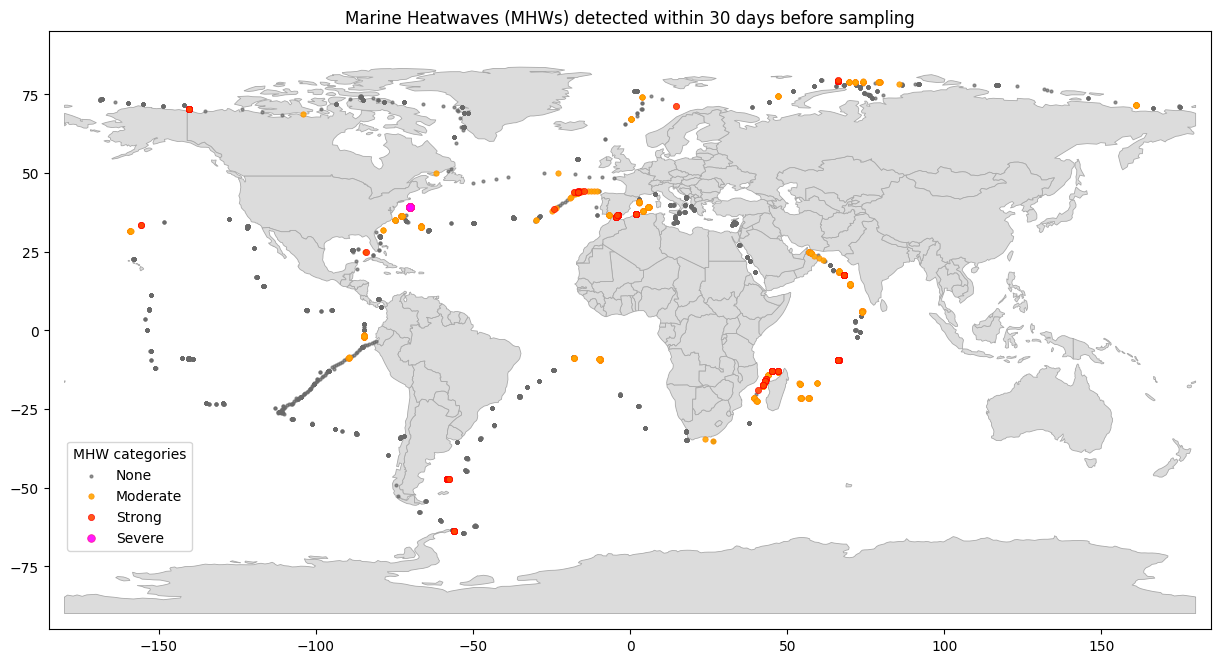

In [7]:
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

df = pd.read_csv("/Users/annaolsen/Desktop/Speciale/DS_thesis/data/TARA_mhws_Dash_2.csv")

df['MHW_category'].fillna("None", inplace=True)

print(df['MHW_category'].value_counts())



strong_df = df[df['MHW_category'] == 'Strong']
moderate_df = df[df['MHW_category'] == 'Moderate']
none_df = df[df['MHW_category'] == 'None']
severe_df = df[df['MHW_category'] == 'Severe']



world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(15, 15))

# Plot world map
world.plot(ax=ax, color='gainsboro', edgecolor='darkgrey', linewidth=0.6)

# Plot closest match points
ax.scatter(none_df['Longitude'], none_df['Latitude'],
           color='dimgrey', label='None', s=4, alpha=0.7)

# Plot original points
ax.scatter(moderate_df['Longitude'], moderate_df['Latitude'],
           color='orange', edgecolor='darkorange', linewidth=0.5, label='Moderate', s=15, alpha=0.9)

# Plot closest match points
ax.scatter(strong_df['Longitude'], strong_df['Latitude'],
           color='orangered', edgecolor='red', linewidth=0.5, label='Strong', s=20, alpha=0.9)

# Plot closest match points
ax.scatter(severe_df['Longitude'], severe_df['Latitude'],
           color='magenta', edgecolor='deeppink', linewidth=0.6, label='Severe', s=30, alpha=0.9)

# Set x-axis limits
ax.set_xlim(-185, 185)
ax.set_ylim(-95, 95)

# Add legend
ax.legend(title="MHW categories", loc='lower left', bbox_to_anchor=(0.01,0.12))  # Adjust the position of the legend (x, y)


# Set title
ax.set_title('Marine Heatwaves (MHWs) detected within 30 days before sampling')

# plt.show()
plt.savefig('/Users/annaolsen/Desktop/Speciale/DS_thesis/mhws_30_tara_cat.png', bbox_inches='tight', dpi=200)

plt.show()


/var/folders/dg/_lhx53rd0n9583q5gqs1fcg80000gn/T/ipykernel_35792/2163072065.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


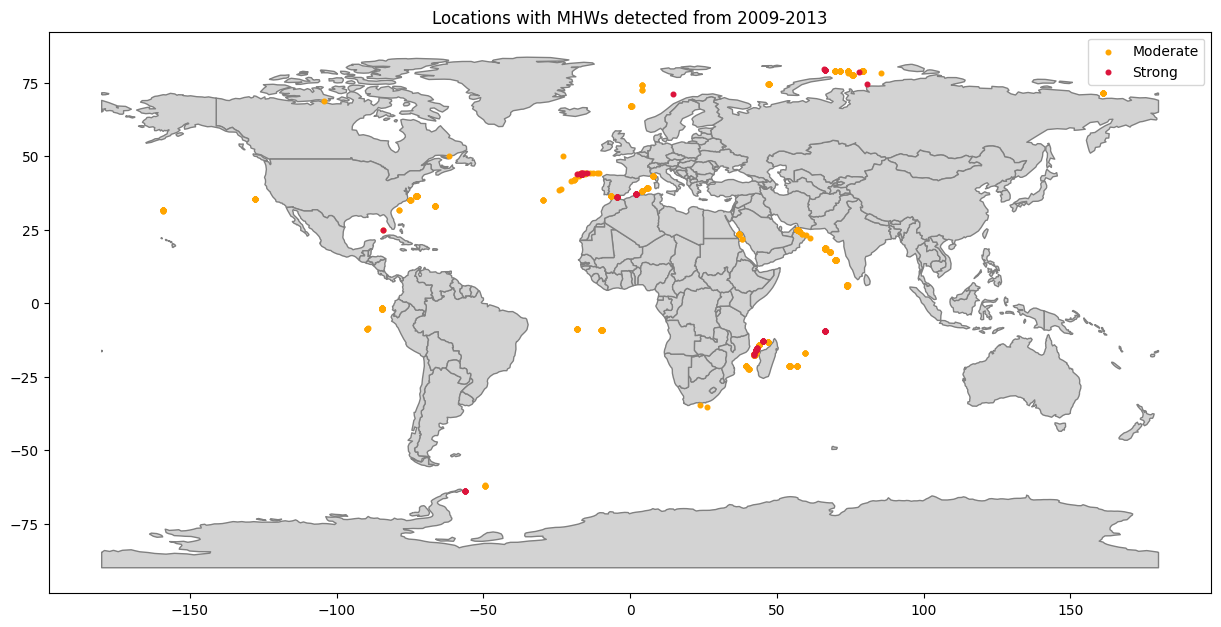

In [20]:

strong_df = filtered_df[filtered_df['category'] == 'Strong']
moderate_df = filtered_df[filtered_df['category'] == 'Moderate']


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(15, 15))

# Plot world map
world.plot(ax=ax, color='lightgray', edgecolor='grey')

# # Plot closest match points
# ax.scatter(no_mhws_df['Longitude'], no_mhws_df['Latitude'],
#            color='black', label='No MHW', s=4)

# Plot original points
ax.scatter(moderate_df['Longitude'], moderate_df['Latitude'],
           color='orange', label='Moderate', s=11)

# Plot closest match points
ax.scatter(strong_df['Longitude'], strong_df['Latitude'],
           color='crimson', label='Strong', s=11)



# Set title
ax.set_title('Locations with MHWs detected from 2009-2013')
# Add legend
ax.legend()

plt.show()
